In [ ]:
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from tqdm import tqdm
from collections import Counter, defaultdict
from random import sample
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch import Tensor
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

In [114]:
data_flag = 'dermamnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [115]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

BATCH_SIZE = 128

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=64)
valid_dataset = DataClass(split='val', transform=data_transform, download=download, size=64)
test_dataset = DataClass(split='test', transform=data_transform, download=download, size=64)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = data.DataLoader(dataset=valid_dataset, batch_size=2*BATCH_SIZE, shuffle=False, num_workers=8)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False, num_workers=8)

Using downloaded and verified file: /home/tomek/.medmnist/dermamnist_64.npz
Using downloaded and verified file: /home/tomek/.medmnist/dermamnist_64.npz
Using downloaded and verified file: /home/tomek/.medmnist/dermamnist_64.npz


In [96]:
Counter(label[0] for _, label in train_dataset)

Counter({np.int64(0): 228,
         np.int64(5): 4693,
         np.int64(4): 779,
         np.int64(2): 769,
         np.int64(1): 359,
         np.int64(6): 99,
         np.int64(3): 80})

Klasy są niezbalansowane coś trzeba zrobić przy klasyfikatorze i generatorze chyba też?

In [117]:
label_to_images = defaultdict(list)

for img, label in test_dataset:
    class_idx = label[0]
    label_to_images[class_idx].append(img)

In [6]:
class MedModel(nn.Module):
    def __init__(self, num_labels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Get ResNet50 model with ImageNet weights
        self.model = models.resnet50(weights='IMAGENET1K_V2')
        # freeze convolution parameters
        for param in self.model.parameters():
            param.requires_grad = False
        num_ftrs = self.model.fc.in_features
        # Fully connected layer with num_labels classes
        self.model.fc = nn.Linear(num_ftrs, num_labels)
    def forward(self, x):
        return self.model(x)

In [248]:
model = MedModel(n_classes)
model = model.to(device)

model

MedModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [ ]:
def compute_class_weights(train_loader, num_classes):
    class_counts = np.zeros(num_classes)
    
    for inputs, labels in train_loader:
        for label in labels:
            class_counts[label.item()] += 1
            
    total_samples = len(train_loader.dataset)
    class_weights = total_samples / (num_classes * class_counts)
    
    return torch.tensor(class_weights, dtype=torch.float).to(device)

In [249]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(weight=compute_class_weights(train_loader, n_classes))
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [260]:
def accuracy(loader, loader_type):
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.squeeze(1)
            outputs = model(images).cpu()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {total} {loader_type} images: {100 * correct / total:.2f} %')
    return 100 * correct / total

In [305]:
def accuracy_sepearate(loader):
    model.eval()

    correct = defaultdict(int)
    total = defaultdict(int)
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.squeeze(1)
            outputs = model(images).cpu()
            _, predicted = torch.max(outputs.data, 1)
            for label, pred in zip(labels, predicted):
                label = label.item()
                total[label] += 1
                correct[label] += pred.item() == label
    return [round(100*c/t,2) for c, t in zip(correct.values(), total.values())]

In [ ]:
# num_epochs = 20

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for inputs, labels in tqdm(train_loader):
#         inputs, labels
#         inputs, labels = inputs.to(device), labels.to(device)
#         labels = labels.squeeze(1)

#         optimizer.zero_grad()

#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     print(f'[%d/{num_epochs}] loss: %.3f' %
#           (epoch+1 ,  running_loss / len(train_dataset)))
#     accuracy(train_loader, 'train')
#     accuracy(val_loader, 'valid')
#     running_loss = 0.0

# print('Finished Training')

100%|██████████| 55/55 [00:08<00:00,  6.37it/s]

[1/20] loss: 0.013


Accuracy of the network on the 7007 train images: 56.23 %
Accuracy of the network on the 1003 valid images: 51.55 %


100%|██████████| 55/55 [00:08<00:00,  6.39it/s]

[2/20] loss: 0.010


Accuracy of the network on the 7007 train images: 59.06 %
Accuracy of the network on the 1003 valid images: 54.44 %


100%|██████████| 55/55 [00:08<00:00,  6.36it/s]

[3/20] loss: 0.009


Accuracy of the network on the 7007 train images: 62.67 %
Accuracy of the network on the 1003 valid images: 55.33 %


100%|██████████| 55/55 [00:08<00:00,  6.37it/s]

[4/20] loss: 0.008


Accuracy of the network on the 7007 train images: 65.91 %
Accuracy of the network on the 1003 valid images: 57.43 %


100%|██████████| 55/55 [00:08<00:00,  6.38it/s]

[5/20] loss: 0.007


Accuracy of the network on the 7007 train images: 67.96 %
Accuracy of the network on the 1003 valid images: 59.92 %


100%|██████████| 55/55 [00:08<00:00,  6.36it/s]

[6/20] loss: 0.007


Accuracy of the network on the 7007 train images: 69.79 %
Accuracy of the network on the 1003 valid images: 61.22 %


100%|██████████| 55/55 [00:08<00:00,  6.37it/s]

[7/20] loss: 0.006


Accuracy of the network on the 7007 train images: 68.55 %
Accuracy of the network on the 1003 valid images: 59.12 %


100%|██████████| 55/55 [00:08<00:00,  6.36it/s]

[8/20] loss: 0.006


Accuracy of the network on the 7007 train images: 70.94 %
Accuracy of the network on the 1003 valid images: 60.72 %


100%|██████████| 55/55 [00:08<00:00,  6.37it/s]

[9/20] loss: 0.006


Accuracy of the network on the 7007 train images: 73.58 %
Accuracy of the network on the 1003 valid images: 62.11 %


100%|██████████| 55/55 [00:08<00:00,  6.38it/s]

[10/20] loss: 0.006


Accuracy of the network on the 7007 train images: 72.57 %
Accuracy of the network on the 1003 valid images: 60.72 %


100%|██████████| 55/55 [00:08<00:00,  6.35it/s]

[11/20] loss: 0.005


Accuracy of the network on the 7007 train images: 74.30 %
Accuracy of the network on the 1003 valid images: 62.81 %


100%|██████████| 55/55 [00:08<00:00,  6.31it/s]

[12/20] loss: 0.005


Accuracy of the network on the 7007 train images: 72.86 %
Accuracy of the network on the 1003 valid images: 60.62 %


100%|██████████| 55/55 [00:08<00:00,  6.34it/s]

[13/20] loss: 0.005


Accuracy of the network on the 7007 train images: 74.13 %
Accuracy of the network on the 1003 valid images: 62.01 %


100%|██████████| 55/55 [00:08<00:00,  6.29it/s]

[14/20] loss: 0.005


Accuracy of the network on the 7007 train images: 74.53 %
Accuracy of the network on the 1003 valid images: 60.82 %


100%|██████████| 55/55 [00:08<00:00,  6.31it/s]

[15/20] loss: 0.005


Accuracy of the network on the 7007 train images: 75.88 %
Accuracy of the network on the 1003 valid images: 62.71 %


100%|██████████| 55/55 [00:08<00:00,  6.35it/s]

[16/20] loss: 0.005


Accuracy of the network on the 7007 train images: 74.91 %
Accuracy of the network on the 1003 valid images: 60.92 %


100%|██████████| 55/55 [00:08<00:00,  6.23it/s]

[17/20] loss: 0.004


Accuracy of the network on the 7007 train images: 74.91 %
Accuracy of the network on the 1003 valid images: 60.22 %


100%|██████████| 55/55 [00:08<00:00,  6.29it/s]

[18/20] loss: 0.004


Accuracy of the network on the 7007 train images: 76.02 %
Accuracy of the network on the 1003 valid images: 60.52 %


100%|██████████| 55/55 [00:08<00:00,  6.30it/s]

[19/20] loss: 0.004


Accuracy of the network on the 7007 train images: 76.34 %
Accuracy of the network on the 1003 valid images: 60.42 %


100%|██████████| 55/55 [00:08<00:00,  6.27it/s]

[20/20] loss: 0.004


Accuracy of the network on the 7007 train images: 77.96 %
Accuracy of the network on the 1003 valid images: 63.91 %
Finished Training


In [252]:
accuracy(test_loader, 'test')

Accuracy of the network on the 2005 test images: 62.59 %


In [ ]:
# torch.save(model, 'real_trained_classifier.pth')
classifier_real = torch.load('real_trained_classifier.pth').to(device)

In [12]:
latent_dim = 100
embedding_dim = 100

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_conditioned_generator = nn.Sequential(
            nn.Embedding(n_classes, embedding_dim),
            nn.Linear(embedding_dim, 16)
        )

        self.latent = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.model = nn.Sequential(
            # input: (B, 513, 4, 4)
            nn.ConvTranspose2d(513, 512, 4, 2, 1, bias=False),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256, momentum=0.1, eps=0.8),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128, momentum=0.1, eps=0.8),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64, momentum=0.1, eps=0.8),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 4, 4)

        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 512, 4, 4)

        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        return image

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
         
     
        self.label_condition_disc = \
        nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 3*64*64))
              
        self.model = \
        nn.Sequential(nn.Conv2d(6, 64, 4, 2, 1, bias=False),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64, 64*2, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*2, 64*4, 4, 3,2, bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*4, 64*8, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True), 
                      nn.Flatten(),
                      nn.Dropout(0.4),
                      nn.Linear(2048, 1),
                      nn.Sigmoid()
                     )
 
    def forward(self, inputs):
        img, label = inputs
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 3, 64, 64)
        concat = torch.cat((img, label_output), dim=1)
        #print(concat.size())
        output = self.model(concat)
        return output

In [15]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [16]:
binary_cross_entropy = torch.nn.BCELoss()

def generator_loss(label, fake_output):
    gen_loss = binary_cross_entropy(label, fake_output)
    #print(gen_loss)
    return gen_loss

def discriminator_loss(label, output):
    disc_loss = binary_cross_entropy(label, output)
    #print(total_loss)
    return disc_loss

In [17]:
# suggested default - beta parameters (decay of first order momentum of gradients)
b1 = 0.5
b2 = 0.999

# suggested default - learning rate
lr = 0.0002

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))

In [ ]:
# num_epochs = 100
# for epoch in range(1, num_epochs+1): 
 
#     D_loss_list, G_loss_list = [], []
    
#     for i, (real_images, labels) in enumerate(tqdm(train_loader)):
#         optimizer_D.zero_grad()
#         real_images = real_images.to(device)
#         labels = labels.to(device)
#         labels = labels.unsqueeze(1).long()
 
       
#         real_target = Variable(torch.ones(real_images.size(0), 1).to(device))
#         fake_target = Variable(torch.zeros(real_images.size(0), 1).to(device))
       
#         D_real_loss = discriminator_loss(discriminator((real_images, labels)), real_target)
#         # print(discriminator(real_images))
#         #D_real_loss.backward()
     
#         noise_vector = torch.randn(real_images.size(0), latent_dim, device=device)  
#         noise_vector = noise_vector.to(device)
         
        
#         generated_image = generator((noise_vector, labels))
#         output = discriminator((generated_image.detach(), labels))
#         D_fake_loss = discriminator_loss(output,  fake_target)
 
     
#         # train with fake
#         #D_fake_loss.backward()
       
#         D_total_loss = (D_real_loss + D_fake_loss) / 2
#         D_loss_list.append(D_total_loss)
       
#         D_total_loss.backward()
#         optimizer_D.step()
 
#         # Train generator with real labels
#         optimizer_G.zero_grad()
#         G_loss = generator_loss(discriminator((generated_image, labels)), real_target)
#         G_loss_list.append(G_loss)
 
#         G_loss.backward()
#         optimizer_G.step()

#     print(
#         "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
#         % (epoch+1, num_epochs, i+1, len(train_loader), D_total_loss.item(), G_loss.item())
#     )

In [21]:
# torch.save(generator, 'sec_gen.pth')
# torch.save(discriminator, 'sec_dis')

generator = torch.load('sec_gen.pth')
discriminator = torch.load('sec_dis')

/tmp/ipykernel_250270/2722281099.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator = torch.load('sec_gen.pth')
/tmp/ipykernel_250270/2722281099.py:5: FutureWarni

In [ ]:
def generate_images(samples=1, only_class=-1):
    generator.eval()
    with torch.no_grad():
        images = []
        for _ in range(samples):
            for label in range(n_classes):
                noise_vector = torch.randn(1, latent_dim, device=device)
                label_tensor = torch.tensor([[label if only_class==-1 else only_class]], dtype=torch.long, device=device)

                prediction = generator([noise_vector, label_tensor])
                images.append([prediction, label_tensor.cpu()])

    return images

In [238]:
import matplotlib.pyplot as plt
import torch

def show_images(images, n, title):
    fig, axes = plt.subplots(1, 7, figsize=(20, 3))

    for idx, img in enumerate(images):
        img_normalized = (img + 1) / 2.0
        
        ax = axes[idx]
        ax.imshow(img_normalized.permute(1, 2, 0).cpu().numpy(), cmap='gray')
        ax.axis('off')

    plt.suptitle(f"{title} images for class {n}: {test_dataset.info['label'][str(n)]}")
    
    plt.show()

In [ ]:
def check_class(n):
    # generated
    generated= [img for img, _ in generate_images(only_class=n)]
    generated = torch.cat(generated, dim=0)

    # real
    real = sample(label_to_images[n], 7)

    show_images(generated, n, 'generated')
    show_images(real, n, 'real')

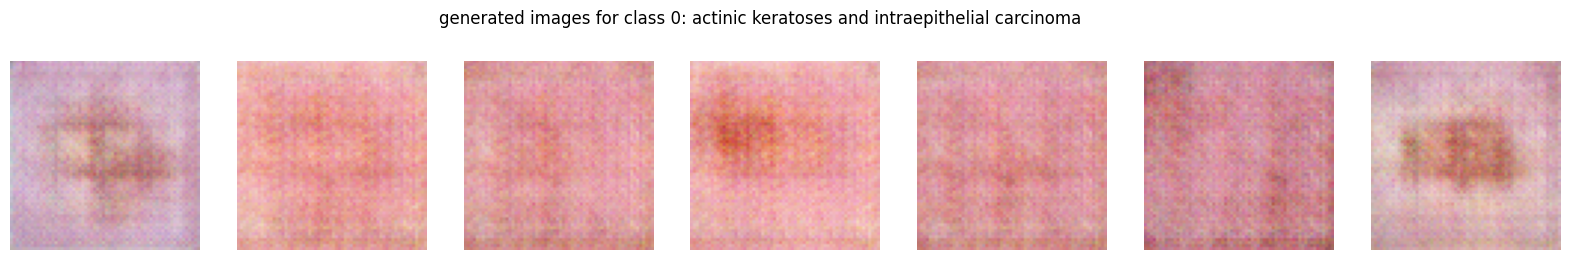

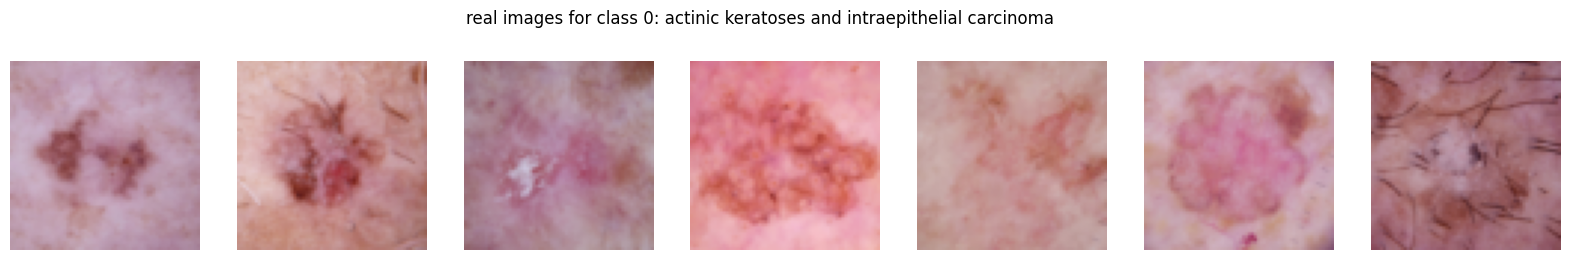

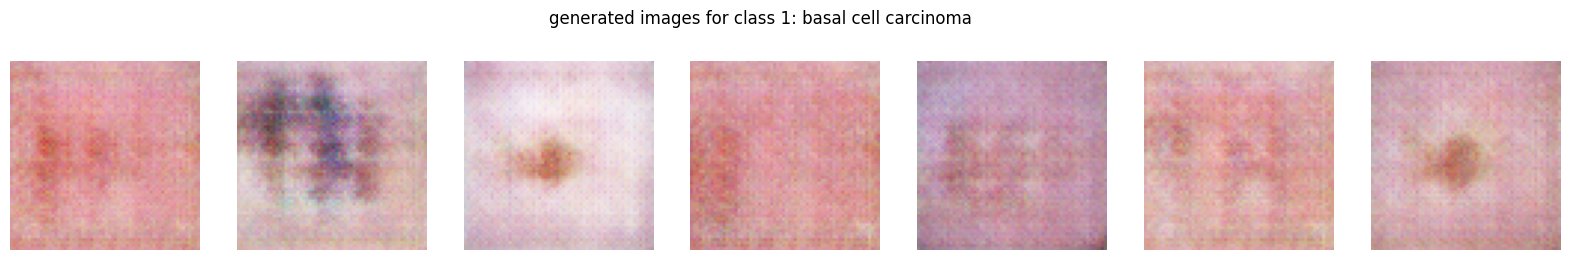

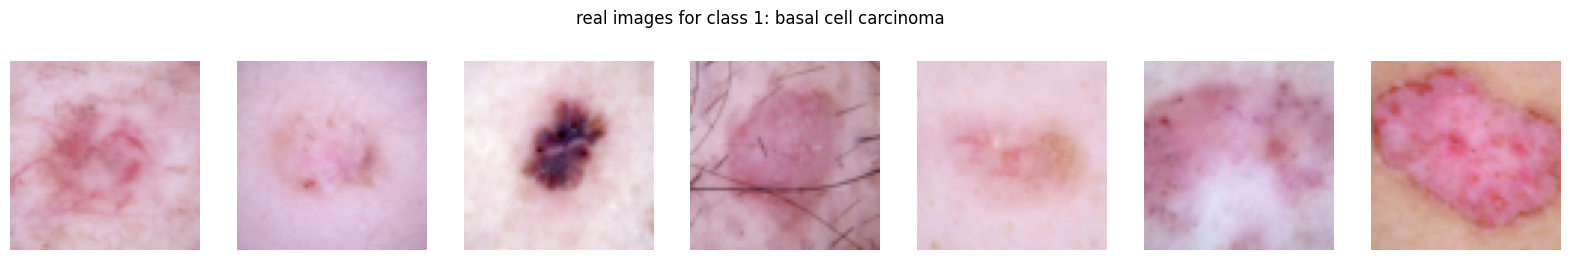

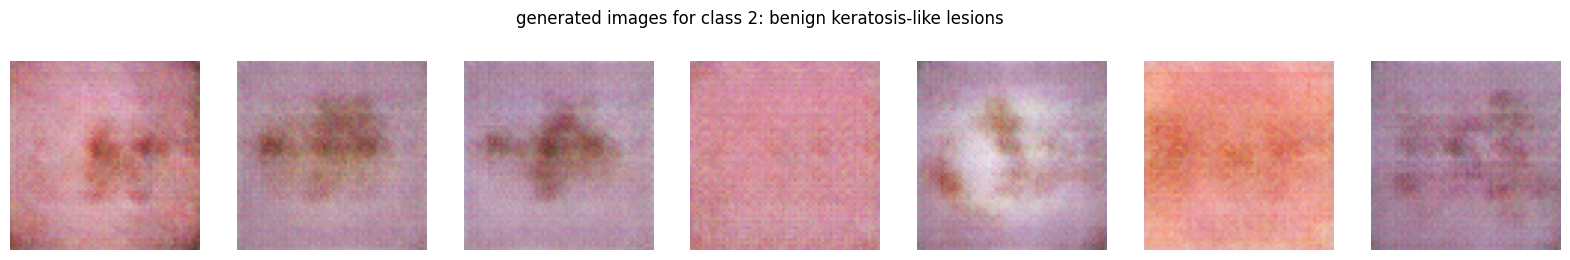

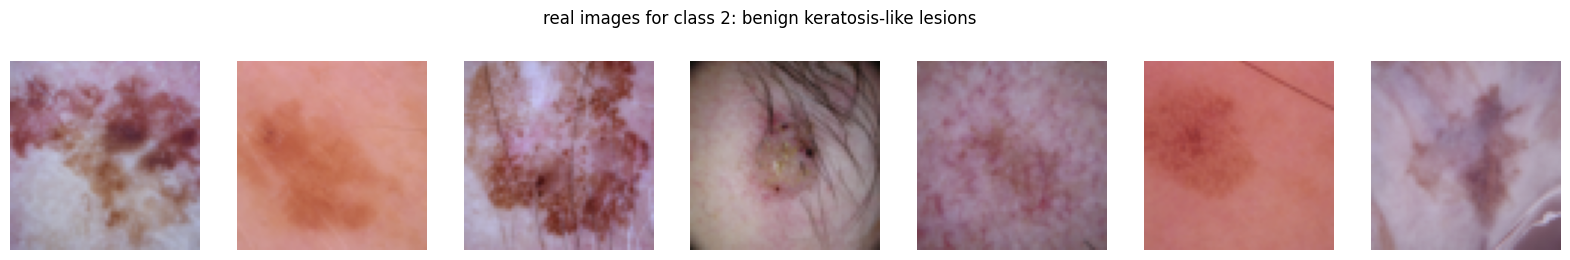

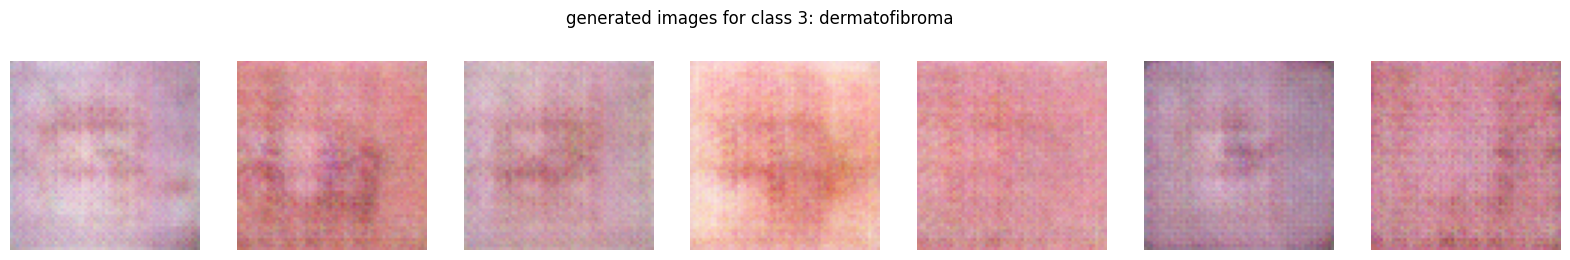

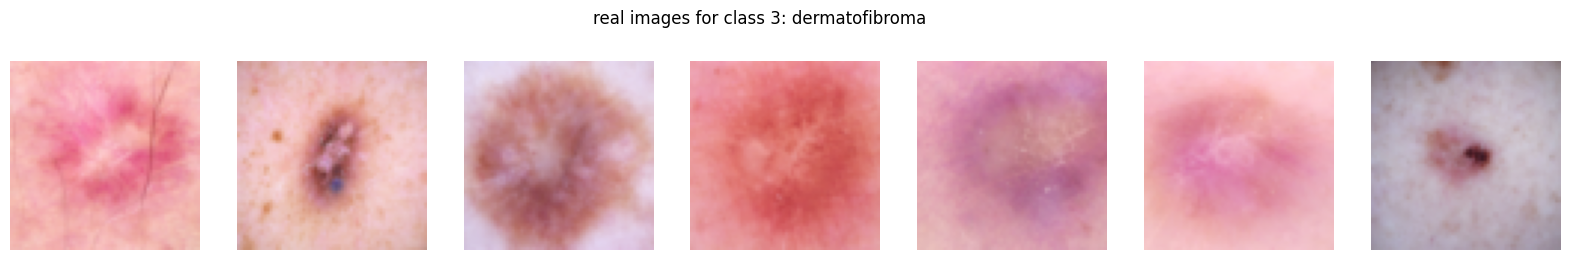

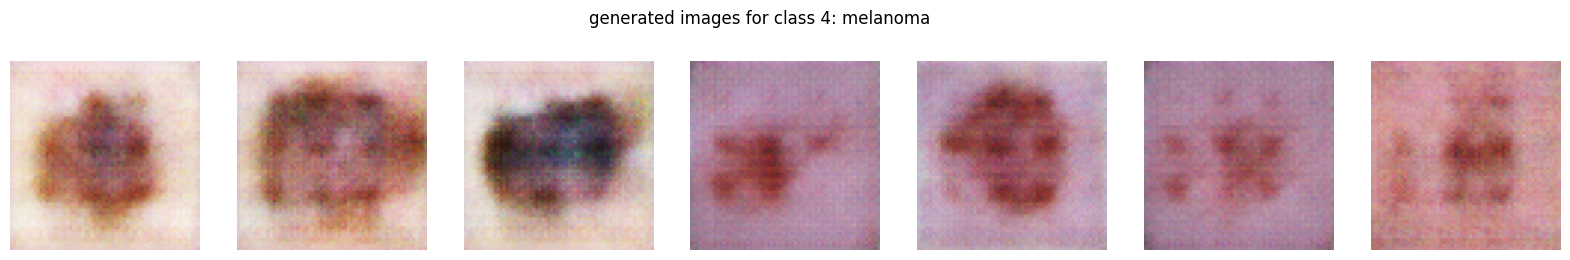

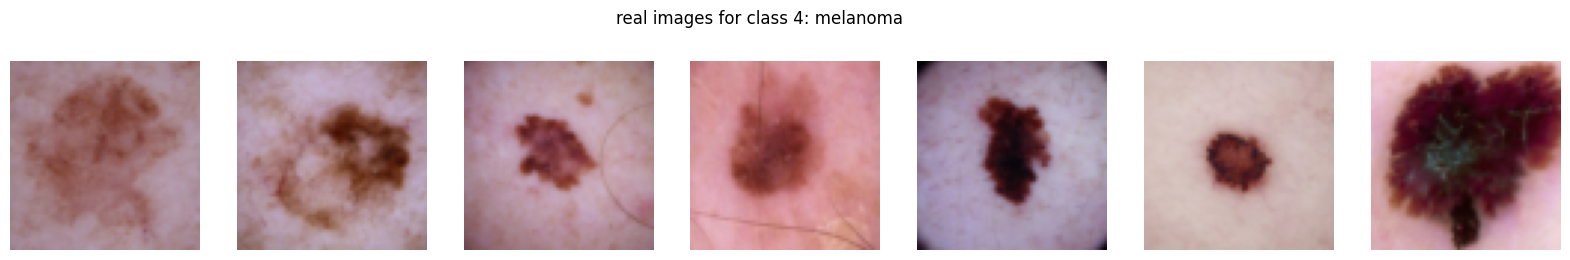

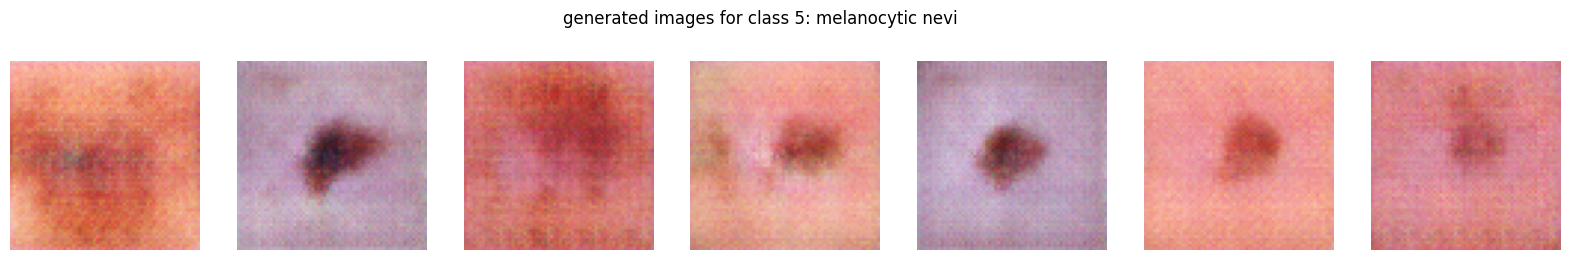

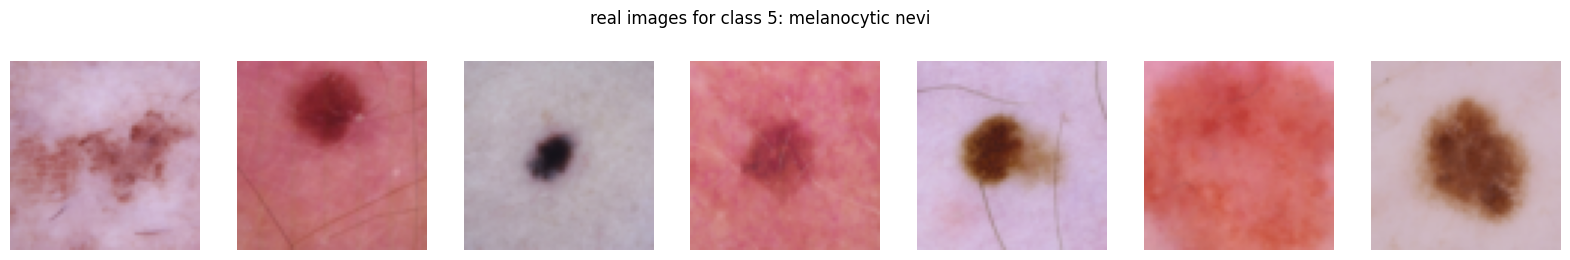

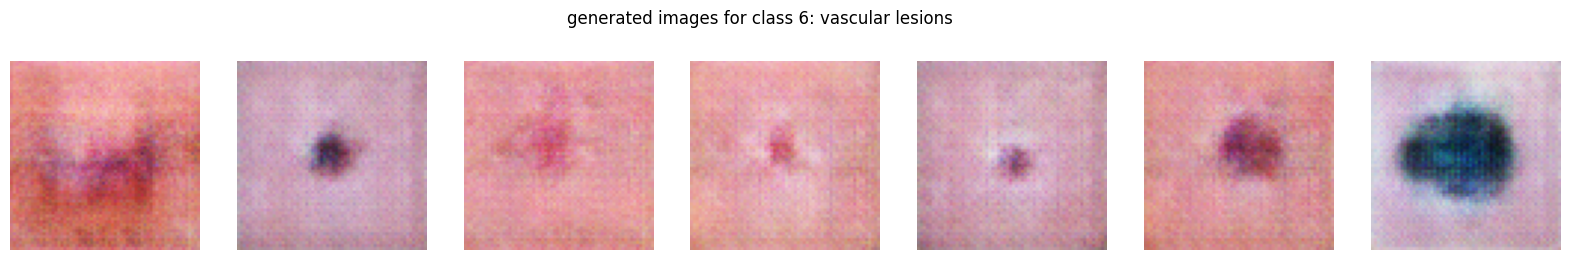

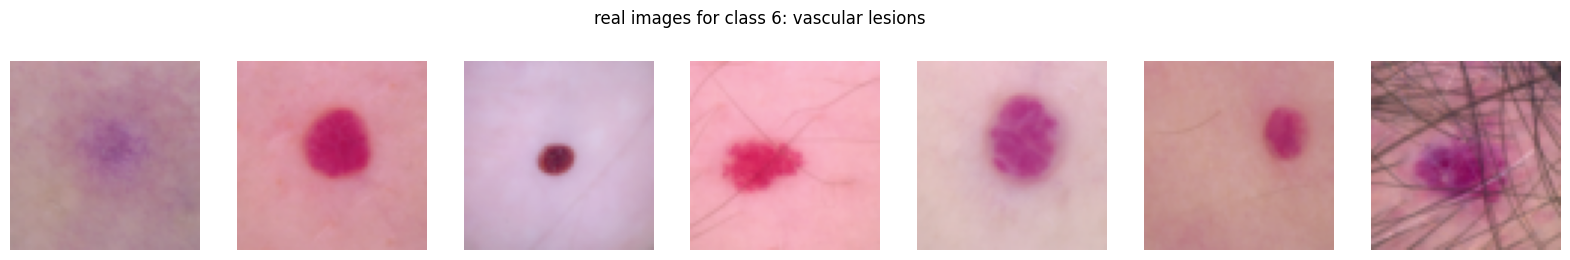

In [258]:
for i in range(7):
    check_class(i)

In [288]:
results = []

for i in range(7):
    results.append(accuracy(generate_images(20, i), f"class {i}"))

print("Mean accuracy: ", round(sum(results)/7, 2), "%")

Accuracy of the network on the 140 class 0 images: 1.43 %
Accuracy of the network on the 140 class 1 images: 10.71 %
Accuracy of the network on the 140 class 2 images: 36.43 %
Accuracy of the network on the 140 class 3 images: 17.86 %
Accuracy of the network on the 140 class 4 images: 20.71 %
Accuracy of the network on the 140 class 5 images: 51.43 %
Accuracy of the network on the 140 class 6 images: 21.43 %
Mean accuracy:  22.86 %


In [308]:
print(accuracy_sepearate(test_loader))
accuracy(test_loader, 'real')

[70.47, 26.09, 42.15, 46.97, 48.64, 49.51, 72.41]
Accuracy of the network on the 2005 real images: 62.59 %


62.593516209476306